In [28]:
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import random
from neal_batched import Neal_batched_Gibbs_sampler
from neal_sequential import Neal_sequential_Gibbs_sampler
# spectral clustering
from sklearn.cluster import SpectralClustering
# import loss
from metrics import loss, greedy_loss
from utils import warm_initializer

In [3]:
seed = 1
random.seed(seed)

In [4]:
# import the data from the ./data folder, .txt files
data = np.loadtxt('./data/email-Eu-core.txt', dtype=int)
assignments = np.loadtxt('./data/email-Eu-core-department-labels.txt', dtype=int)

# turn data into an adjacency matrix
G = nx.Graph()
G.add_edges_from(data)
A = nx.adjacency_matrix(G).toarray()


In [1]:
z_true = assignments[:,1]

NameError: name 'assignments' is not defined

In [6]:
n = A.shape[0]
k = len(np.unique(z_true))

In [7]:
print('Number of nodes:', n)
print('Number of communities:', k)

Number of nodes: 1005
Number of communities: 42


In [8]:
# count unique values in z_true
np.unique(z_true).shape[0]

42

In [118]:
# erase communities smaller than 16 nodes
min_size = 30
unique, counts = np.unique(z_true, return_counts=True)
communities = dict(zip(unique, counts))
for key in list(communities.keys()):
    if communities[key] < min_size:
        A = np.delete(A, np.where(z_true == key), axis=0)
        A = np.delete(A, np.where(z_true == key), axis=1)
        z_true = np.delete(z_true, np.where(z_true == key))

n = A.shape[0]
k = len(np.unique(z_true))

In [9]:
# rename communities from 0 to k-1
for i, z in enumerate(np.unique(z_true)):
    z_true[z_true == z] = i

In [10]:
print('Number of nodes:', n)
print('Number of communities:', k)

Number of nodes: 1005
Number of communities: 42


In [30]:
n_iter = 100
gamma = 1
ap = 1
bp = 1
aq = 1
bq = 1
z_init = warm_initializer(z_true, alpha = 0., n=n, k=k)
sampler = Neal_batched_Gibbs_sampler(A, z_init, ap, bp, aq, bq, gamma = gamma)
sampler.run(5000)
# initialize the sampler


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:33<00:00, 18.27it/s]


In [31]:
z = sampler.get_z_list()[-1]
greedy_loss(z, z_true)

0.5850746268656717

In [32]:
sampler = Neal_sequential_Gibbs_sampler(A, z_init, ap, bp, aq, bq, gamma = gamma)
sampler.run(1000)

z = sampler.get_z_list()[-1]
greedy_loss(z, z_true)

100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


0.5253731343283582

In [56]:
# use spectral clustering to compare
sc = SpectralClustering(n_clusters=k, affinity="precomputed", random_state=seed)
z_sc = sc.fit_predict(A)
greedy_loss(z_sc, z_true)
compute_modularity(A, z_sc)

c:\Users\feder\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


0.1346631741977715

In [52]:
z_init = z_sc
sampler = Neal_batched_Gibbs_sampler(A, z_init, ap, bp, aq, bq, gamma = gamma)
sampler.run(10000)

z = sampler.get_z_list()[-1]
greedy_loss(z, z_true)

100%|██████████| 10000/10000 [08:27<00:00, 19.70it/s]


0.6009950248756218

In [58]:
# do a majority vote of the last 25 samples for each node
z_majority = np.zeros(n)
z_list = sampler.get_z_list()
z_array = np.array(z_list)
for i in range(n):
    z_majority[i] = np.argmax(np.bincount(z_array[-100:,i]))

greedy_loss(z_majority, z_true)
compute_modularity(A, z_majority)

0.29750466977664536

In [124]:
# use Gibbs on spectral clustering
n_iter = 1000
z_init = z_sc
sampler = Neal_batched_Gibbs_sampler(A, z_init, ap, bp, aq, bq, gamma = 1)
sampler.run(n_iter)
z = sampler.get_z_list()[-1]
print(loss(z, z_true, verbose = False))

z_list = sampler.get_z_list()[:-5]
# majority vote
z_majority = np.zeros(n)
for i in range(n):
    z_majority[i] = np.argmax(np.bincount([z[i] for z in z_list]))

z_majority = z_majority.astype(int)
print(loss(z_majority, z_true, verbose = False))


100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]


(0.31802721088435376, (2, 6, 5, 0, 8, 3, 1, 9, 7, 4))
(0.3163265306122449, (2, 6, 5, 0, 8, 3, 1, 9, 7, 4))


# Extra


In [125]:
# import the data from the ./data folder, .txt files
data = np.loadtxt('./data/email-Eu-core.txt', dtype=int)
assignments = np.loadtxt('./data/email-Eu-core-department-labels.txt', dtype=int)

# turn data into an adjacency matrix
G = nx.Graph()
G.add_edges_from(data)
A = nx.adjacency_matrix(G).toarray()

z_true = assignments[:,1]

n = A.shape[0]
k = len(np.unique(z_true))
print('Number of nodes:', n)
print('Number of communities:', k)

Number of nodes: 1005
Number of communities: 42


In [171]:
import itertools
def generate_tuples(list1, list2):
    return list(itertools.product(list1, list2))

# compute within connectivity probabilities
community_sizes = np.bincount(z_true)
A_l = np.tril(A)
p = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        t = generate_tuples(np.where(z_true==i)[0], np.where(z_true==j)[0])
        if i != j:
            sum = 0
            for tup in t:
                sum += A_l[tup]
            p[i,j] = sum / (community_sizes[i] * community_sizes[j])
        else:
            sum = 0
            for tup in t:
                sum += A_l[tup]
            p[i,j] = sum / (community_sizes[i] * (community_sizes[i] - 1))

C:\Users\feder\AppData\Local\Temp\ipykernel_30892\2570611643.py:21: RuntimeWarning: invalid value encountered in scalar divide
  p[i,j] = sum / (community_sizes[i] * (community_sizes[i] - 1))


In [173]:
# substitute nans with 0
p[np.isnan(p)] = 0

In [187]:
np.sort(np.bincount(z_true))

array([  1,   1,   2,   3,   3,   4,   4,   5,   6,   6,   8,   8,   9,
         9,  10,  10,  12,  13,  13,  13,  14,  15,  18,  19,  22,  25,
        25,  26,  27,  28,  29,  29,  32,  35,  39,  49,  51,  55,  61,
        65,  92, 109], dtype=int64)

Mean diag(p): 0.2515399226206655
Mean off_diag(p): 0.015278752218190554


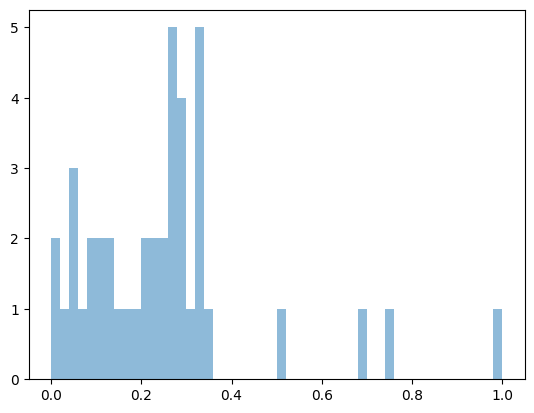

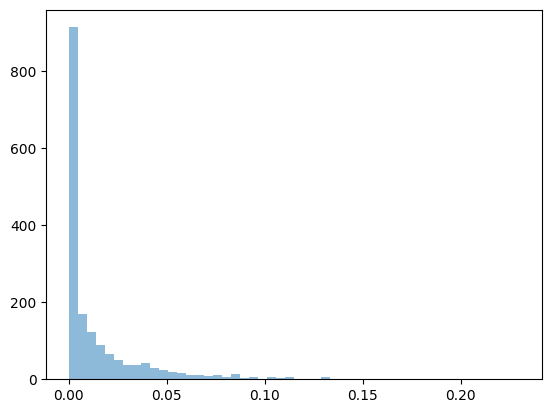

In [175]:
# some stats of diag(p) and off_diag(p)
print('Mean diag(p):', np.mean(np.diag(p)))

print('Mean off_diag(p):', np.mean(p[~np.eye(p.shape[0],dtype=bool)]))

# histograms
plt.hist(np.diag(p), bins=50, alpha=0.5, label='diag(p)')
plt.show()
plt.hist(p[~np.eye(p.shape[0],dtype=bool)], bins=50, alpha=0.5, label='off_diag(p)')
plt.show()

In [48]:
import time

# pick a serious n
n = 1000
k = 10
# generate a random assignment
z_true = np.random.randint(0, k, n)
# now use warm_intializer to know the loss
z_init = warm_initializer(z_true, alpha = 0.4, n=n, k=k)
# check the true loss
start_time = time.time()
true_loss = loss(z_true, z_init)
end_time = time.time()
print(f"True loss: {true_loss}, Time taken: {end_time - start_time} seconds")

# check the greedy loss
start_time = time.time()
greedy_loss_value = greedy_loss(z_true, z_init)
end_time = time.time()
print(f"Greedy loss: {greedy_loss_value}, Time taken: {end_time - start_time} seconds")

True loss: (0.4, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)), Time taken: 391.7437846660614 seconds
Greedy loss: 0.4, Time taken: 0.015753746032714844 seconds
